# Update global wave drag coefficient to mask the shallow seas

In [1]:
%matplotlib inline

import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.colors as colors
from dask.distributed import Client
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from gsw import f, Nsquared, p_from_z, z_from_p

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_drag = '/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_2d_global.nc'
file_stat = '/g/data/nm03/lxy581/archive/tides_025_SAL_JSL/output011/ocean_static.nc'
file_topo = '/home/581/lxy581/tidal_param/MOM6-examples/ocean_only/tides_025/INPUT/ocean_topog.nc'

In [3]:
data = xr.open_dataset(file_drag)
stat = xr.open_dataset(file_stat)

In [4]:
lon = stat['geolon']
lat = stat['geolat']
depth = stat['deptho']
yh, xh = stat.yh, stat.xh

In [5]:
fac_dep = xr.where(depth > 1000, 1, np.nan) 

In [6]:
sigma_mag = np.array(data['sigma_mag']) * np.array(fac_dep)
sigma_xx = np.array(data['sigma_xx']) * np.array(fac_dep)
sigma_yy = np.array(data['sigma_yy']) * np.array(fac_dep)
sigma_xy = np.array(data['sigma_xy']) * np.array(fac_dep)

In [7]:
topog = xr.open_dataset(file_topo)
depth_z = np.array(topog.depth)
depth_z[depth_z==0]=np.nan
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_z),
                                }, 
                      coords={'lon': (('yh', 'xh'), np.array(lon)),
                              'lat': (('yh', 'xh'), np.array(lat))})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

In [8]:
SAH_ds = xr.Dataset(data_vars={'sigma_mag': (["yh","xh"], sigma_mag),
                               'sigma_xx': (["yh","xh"], sigma_xx),
                               'sigma_yy': (["yh","xh"], sigma_yy),
                               'sigma_xy': (["yh","xh"], sigma_xy),
                              },
                    coords={'lon': (["yh","xh"], np.array(lon)), 
                            'lat': (["yh","xh"], np.array(lat))},
                    attrs={'long_name': 'SAH drag coefficient (M2)', 'units': 'm second-1'}
                   )
SAH_ds.to_netcdf('/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_2d_global_masked.nc')

In [9]:
def plot_global(lon,lat,sigma,vmin,vmax,title,cmap):
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land.plot.contourf(ax=ax1, x='lon', y='lat', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, x='lon', y='lat', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    p1 = ax1.pcolormesh(lon, lat, sigma, transform=ccrs.PlateCarree(), cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.title(title)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel(r'$\sigma$ (m s$^{-1}$)');
    return 

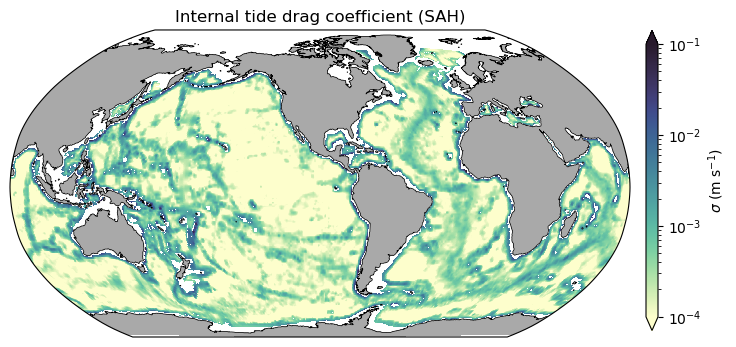

In [10]:
plot_global(SAH_ds['lon'],SAH_ds['lat'],SAH_ds['sigma_mag'],1e-4,1e-1,'Internal tide drag coefficient (SAH)',cmap=cm.cm.deep)